<a href="https://colab.research.google.com/github/songqsh/foo1/blob/master/src/ode02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

__Goal__

We want to solve ODE
$$u''(x) - 2 = 0, u(1) = u(-1) = 0, x\in [-1,1]$$
with neural network and compare this with true solution $u(x) = x^2 - 1$.

__Method__

- Build a neural network, say $v(x;w)$, where $x$ is 1-d input and $w$ is weight. 
- Set loss function as
$$l(w) = \frac{1}{10} 
\sum_{j=1}^{10} \Big(\frac{\partial^2}{\partial_{xx}} v(j/10, w) - 1 \Big)^2 + (v(0) - 1)^2 + (v(1) - 1)^2.$$
- Use an optimizer to minimize the loss


In [0]:
import torch
import torch.nn as nn
from torch.autograd import grad

import numpy as np
import matplotlib.pyplot as plt

In [0]:
#parameters
diffusion = 1.
drift = 0.
run_cost = -2.
l_val = 0.
r_val = 0.

l_end = -1.
r_end = 1.
mesh_n = 20
mesh_x = torch.linspace(l_end, r_end, mesh_n +1, dtype = torch.float, requires_grad=True).reshape(mesh_n+1,1)


In [3]:
H = 5 #number of hidden layer
model = nn.Sequential(
    nn.Linear(1, H), 
    nn.Sigmoid(),
    nn.Linear(H, 1),
)

for p in model.parameters():
  print(p)
#model(torch.randn(5,1))

Parameter containing:
tensor([[-0.8882],
        [ 0.8753],
        [-0.9653],
        [ 0.5660],
        [ 0.3220]], requires_grad=True)
Parameter containing:
tensor([-0.4925,  0.6521, -0.5398, -0.6240,  0.4771], requires_grad=True)
Parameter containing:
tensor([[ 0.2002,  0.4125, -0.3446, -0.3416,  0.1140]], requires_grad=True)
Parameter containing:
tensor([-0.3247], requires_grad=True)


In [0]:
def loss1(model, mesh_x, drift, run_cost): #loss in the interior
  loss = 0.
  for x in mesh_x[1:]:
    y = model(x) #function value
    y_g1 = grad(y, x, create_graph=True)[0] #first order derivative

    y_g2 = grad(y_g1, x, create_graph=True)[0] #second order
    #print('y_g2', y_g2) 

    loss = loss + torch.pow(y_g2*diffusion + y_g1*drift + run_cost, 2)
    
  return torch.div(loss, mesh_x.shape[0])

#loss_total = loss interior + loss boundary
def loss_tot(model, mesh_x, drfit, run_cost, l_val, r_val):
  l1 = loss1(model, mesh_x, drift, run_cost) #loss interior
  l0 = torch.pow(model(mesh_x[0]) - l_val, 2) + \
        torch.pow(model(mesh_x[-1]) - r_val, 2) #loss boundary
  return torch.add(l1,l0)

#loss_tot(model, mesh_x, drift, run_cost, l_val, r_val)  

In [0]:
#optimizer
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [6]:
# Train the model
#num_epochs = 40
epoch_n = 400
print_n = 10
epoch_per_print= np.floor(epoch_n/print_n)

for epoch in range(epoch_n):

    # Forward pass
    loss = loss_tot(model, mesh_x, drift, run_cost, l_val, r_val)  
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % epoch_per_print == 0:
      print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, epoch_n, loss.item()))

Epoch [40/400], Loss: 3.4569
Epoch [80/400], Loss: 2.0598
Epoch [120/400], Loss: 1.3218
Epoch [160/400], Loss: 0.6108
Epoch [200/400], Loss: 0.1335
Epoch [240/400], Loss: 0.0326
Epoch [280/400], Loss: 0.0181
Epoch [320/400], Loss: 0.0154
Epoch [360/400], Loss: 0.0144
Epoch [400/400], Loss: 0.0136


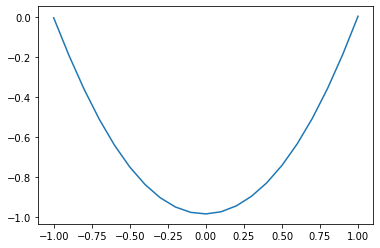

In [7]:
x_np = mesh_x.detach().numpy()
y_np = model(mesh_x).detach().numpy()
plt.plot(x_np, y_np)